### loading the data

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import re

In [2]:
# stripping html
def strip_html(row):
    
    soup = BeautifulSoup(str(row["cooked"]))
    for e in soup.find_all("code"):
        e.decompose() # remove code content
    
    clean_text = soup.get_text() # get only text without html tags
    clean_text = re.sub(r'\s+', ' ', clean_text).strip() # remove extra whitespace

    return clean_text

In [3]:
df_processing = pd.read_csv("combined_posts_processing.csv", low_memory=False)
df_cinder = pd.read_csv("combined_posts_cinder.csv")

In [5]:
df_processing = df_processing[['id', 'created_at', 'cooked', 'post_number', 'post_type', 'topic_id', 'topic_slug', 'user_id']].copy()
df_cinder = df_cinder[['id', 'created_at', 'cooked', 'post_number', 'post_type', 'topic_id', 'topic_slug', 'user_id']].copy()

In [6]:
df_processing['strip_cooked'] = df_processing.apply(strip_html, axis=1)
df_cinder['strip_cooked'] = df_cinder.apply(strip_html, axis=1)

_________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

### generating embeddings

In [8]:
# embeddings
from sentence_transformers import SentenceTransformer
from tqdm.autonotebook import tqdm, trange
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [11]:
index = 0
def embed(text):
    global index
    print(index)
    index += 1
    e = model.encode(text).tolist() 
    return e

In [12]:
df_processing['embedding'] = df_processing['strip_cooked'].apply(embed)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [13]:
df_cinder['embedding'] = df_cinder['strip_cooked'].apply(embed)

95481
95482
95483
95484
95485
95486
95487
95488
95489
95490
95491
95492
95493
95494
95495
95496
95497
95498
95499
95500
95501
95502
95503
95504
95505
95506
95507
95508
95509
95510
95511
95512
95513
95514
95515
95516
95517
95518
95519
95520
95521
95522
95523
95524
95525
95526
95527
95528
95529
95530
95531
95532
95533
95534
95535
95536
95537
95538
95539
95540
95541
95542
95543
95544
95545
95546
95547
95548
95549
95550
95551
95552
95553
95554
95555
95556
95557
95558
95559
95560
95561
95562
95563
95564
95565
95566
95567
95568
95569
95570
95571
95572
95573
95574
95575
95576
95577
95578
95579
95580
95581
95582
95583
95584
95585
95586
95587
95588
95589
95590
95591
95592
95593
95594
95595
95596
95597
95598
95599
95600
95601
95602
95603
95604
95605
95606
95607
95608
95609
95610
95611
95612
95613
95614
95615
95616
95617
95618
95619
95620
95621
95622
95623
95624
95625
95626
95627
95628
95629
95630
95631
95632
95633
95634
95635
95636
95637
95638
95639
95640
95641
95642
95643
95644
95645
95646
9564

In [14]:
df_processing['embedding']

0        [-0.36641186475753784, 0.11251115798950195, -0...
1        [-0.12211921066045761, 0.05992533639073372, -0...
2        [-0.26964011788368225, -0.08623313158750534, -...
3        [-0.08925458788871765, 0.07353352010250092, -0...
4        [0.06090740114450455, -0.05624615401029587, -0...
                               ...                        
95476    [-0.663750410079956, 0.04926934465765953, 0.29...
95477    [0.08918800204992294, -0.48319342732429504, -0...
95478    [-0.4776681363582611, 0.1659250408411026, -0.0...
95479    [-0.3756575584411621, 0.024883875623345375, -0...
95480    [-0.17646895349025726, -0.0364152230322361, -0...
Name: embedding, Length: 95481, dtype: object

_____________________________________________________________________________________________________________________________________________________________

### UMAP

In [15]:
# umap
from umap import UMAP
import numpy as np

In [16]:
def mapper(embedding, n_components=2, n_neighbors=15, min_dist=0.1, metric='euclidean'):
    umap_params = {
        'random_state': 42,
        'n_components': n_components,
        'n_neighbors': n_neighbors,
        'min_dist': min_dist,
        'metric': metric
    }

    # computing UMAP embeddings
    reducer = UMAP(**umap_params)
    mapped = reducer.fit_transform(embedding)

    return reducer, mapped

In [17]:
embeddings_processing = np.array(df_processing['embedding'].tolist())
embeddings_cinder = np.array(df_cinder['embedding'].tolist())

In [18]:
_, mapped_processing = mapper(embeddings_processing)

c:\Users\Imaji Kasih\PycharmProjects\RNDRScrape_discourse-archive - Copy\rndr_venv\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [19]:
_, mapped_cinder = mapper(embeddings_cinder)

c:\Users\Imaji Kasih\PycharmProjects\RNDRScrape_discourse-archive - Copy\rndr_venv\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [20]:
df_processing['x'], df_processing['y'] = mapped_processing[:, 0], mapped_processing[:, 1]
df_cinder['x'], df_cinder['y'] = mapped_cinder[:, 0], mapped_cinder[:, 1]

In [21]:
import matplotlib.pyplot as plt

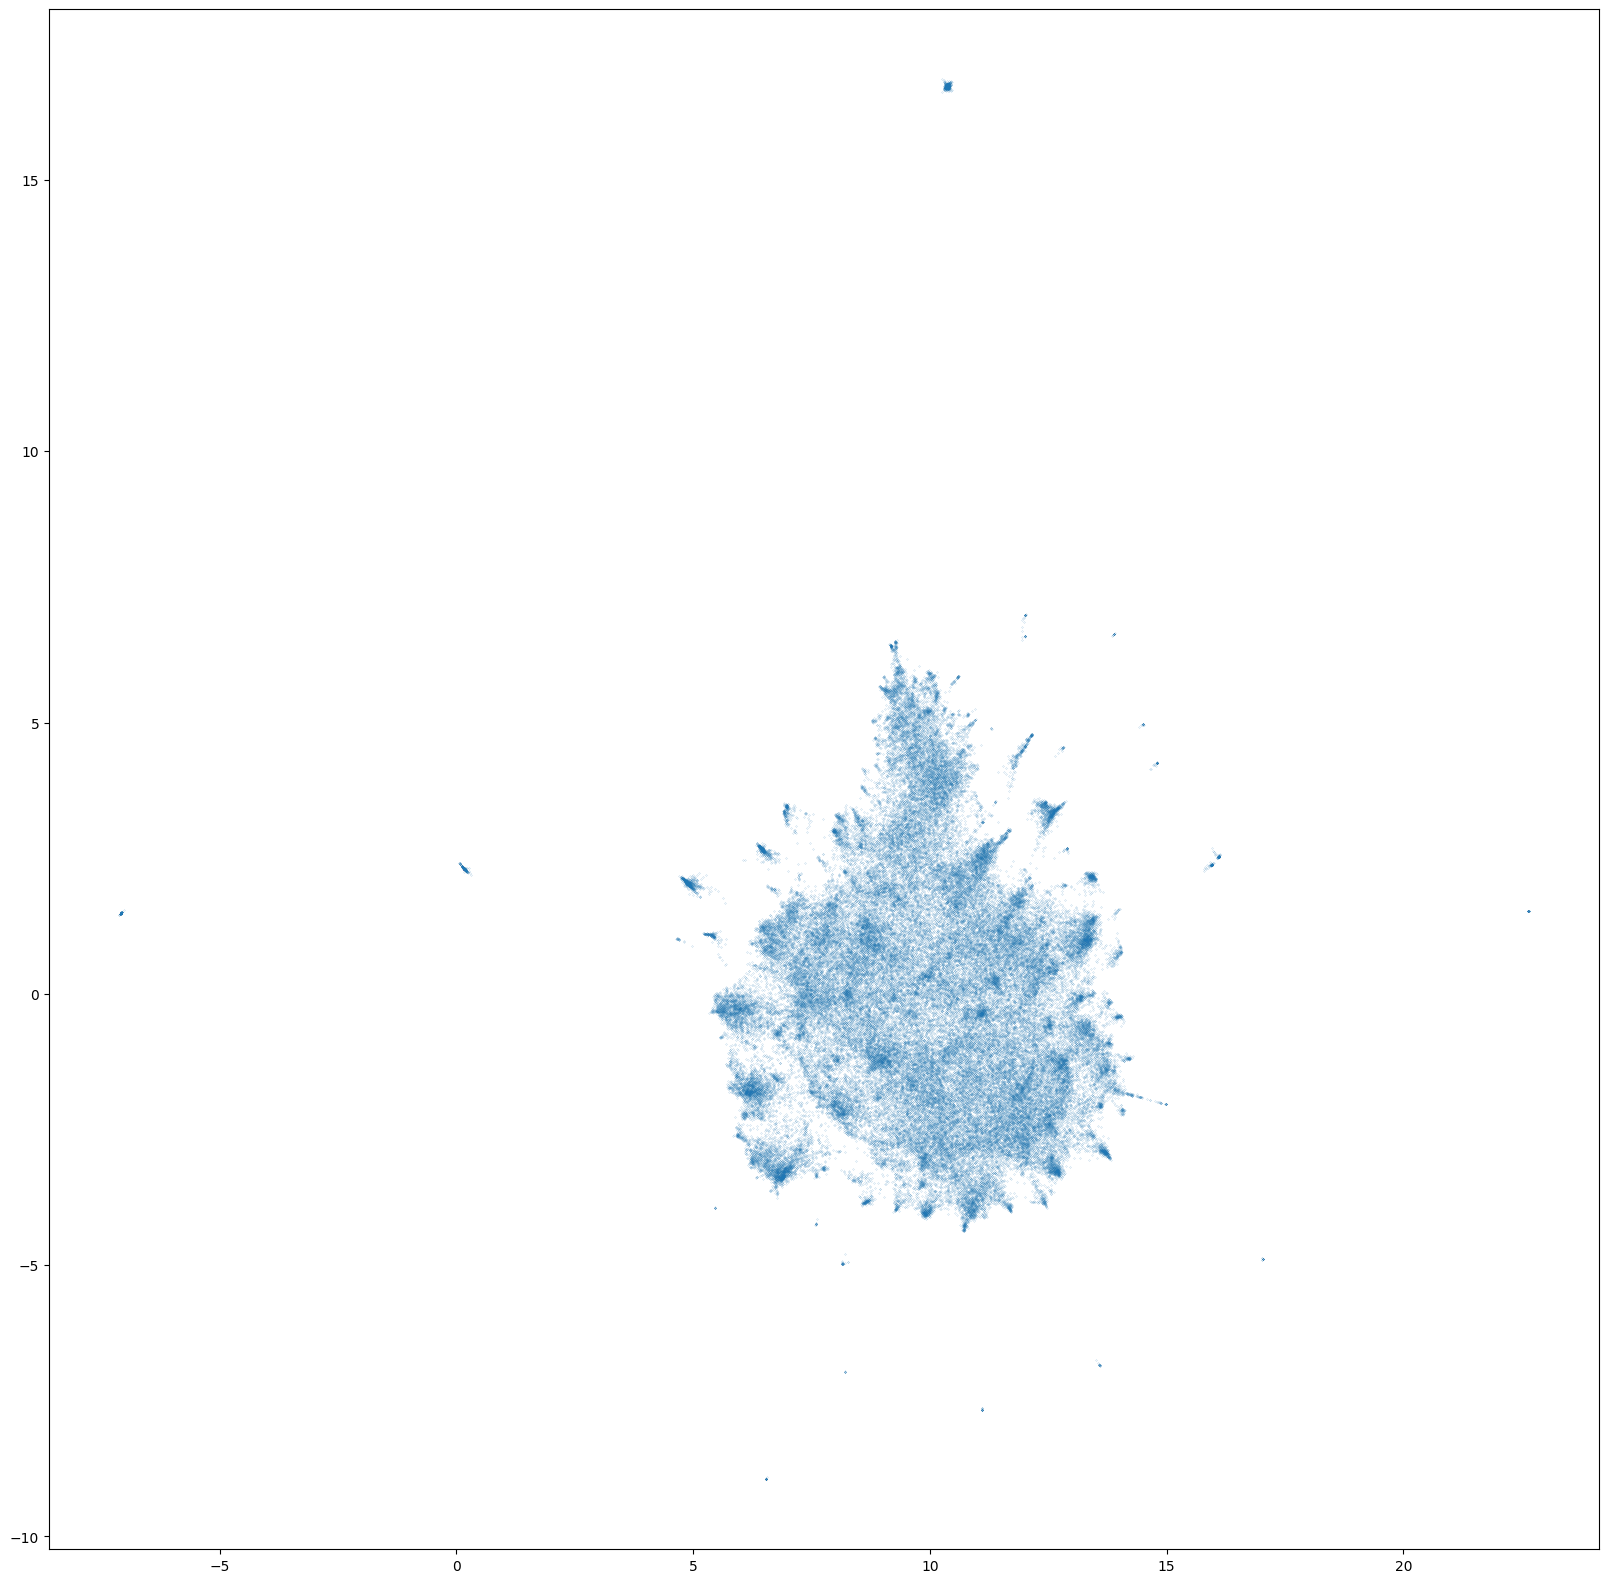

In [22]:
plt.figure(figsize=(20, 20))  
plt.scatter(df_processing["x"], df_processing["y"], s=0.01)

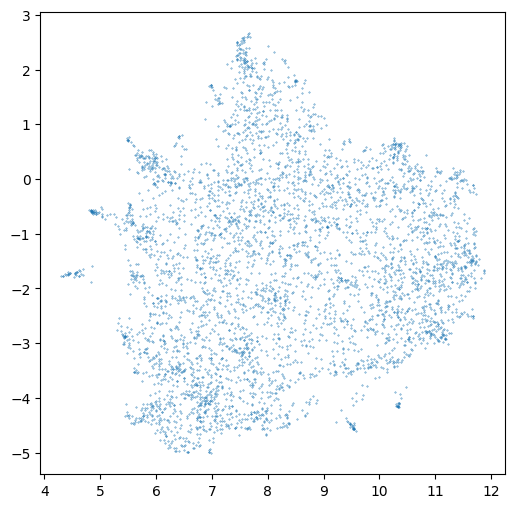

In [23]:
plt.figure(figsize=(6, 6)) 
plt.scatter(df_cinder["x"], df_cinder["y"], s=0.1)

_________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

### HDBSCAN

In [24]:
# hdbscan
from hdbscan import HDBSCAN
from scipy.sparse import csr_matrix

In [25]:
def cluster(map, min_cluster_size=30, min_samples=5, cluster_selection_epsilon=0.2, cluster_selection_method='eom'): 

    hdbscan_params = {
        'min_cluster_size': min_cluster_size, 
        'min_samples': min_samples, 
        'cluster_selection_epsilon': cluster_selection_epsilon, 
        'cluster_selection_method': cluster_selection_method # 'leaf'
    }

    
    # Ensure the input is a dense matrix if it's a sparse one
    if isinstance(map, csr_matrix):
        embedding = map 
    else:
        embedding = map.to_numpy()  # Handle pandas DataFrame or numpy array
    
    clusterer = HDBSCAN(**hdbscan_params)
    clustered = clusterer.fit_predict(embedding)

    return clusterer, clustered

In [26]:
# if we cluster based on umap
_, df_processing['cluster'] = cluster(df_processing[['x', 'y']])
_, df_cinder['cluster'] = cluster(df_cinder[['x', 'y']])

In [27]:
# if we cluster based on embedding
_, df_processing['cluster_e'] = cluster(pd.DataFrame(embeddings_processing))
_, df_cinder['cluster_e'] = cluster(pd.DataFrame(embeddings_cinder))

In [72]:
# _, df_processing['cluster'] = cluster(df_processing[['x', 'y']], min_cluster_size=30, min_samples=5, cluster_selection_epsilon=0.5, cluster_selection_method='leaf')

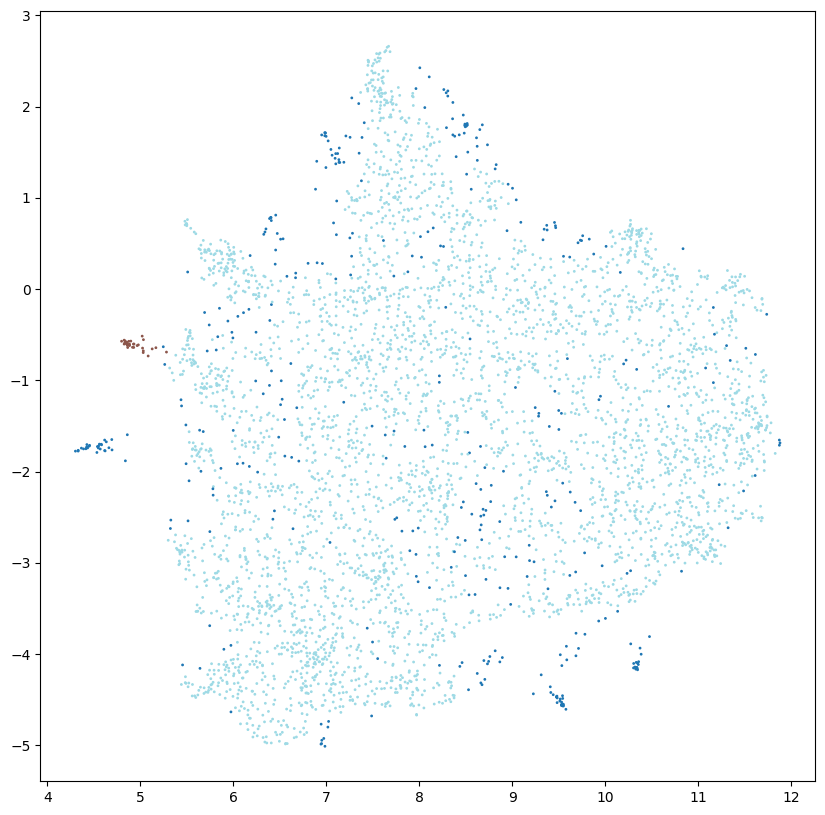

In [29]:
plt.figure(figsize=(10, 10))
plt.scatter(df_cinder["x"], df_cinder["y"], s=1, c=df_cinder['cluster'], cmap=plt.get_cmap('tab20'))

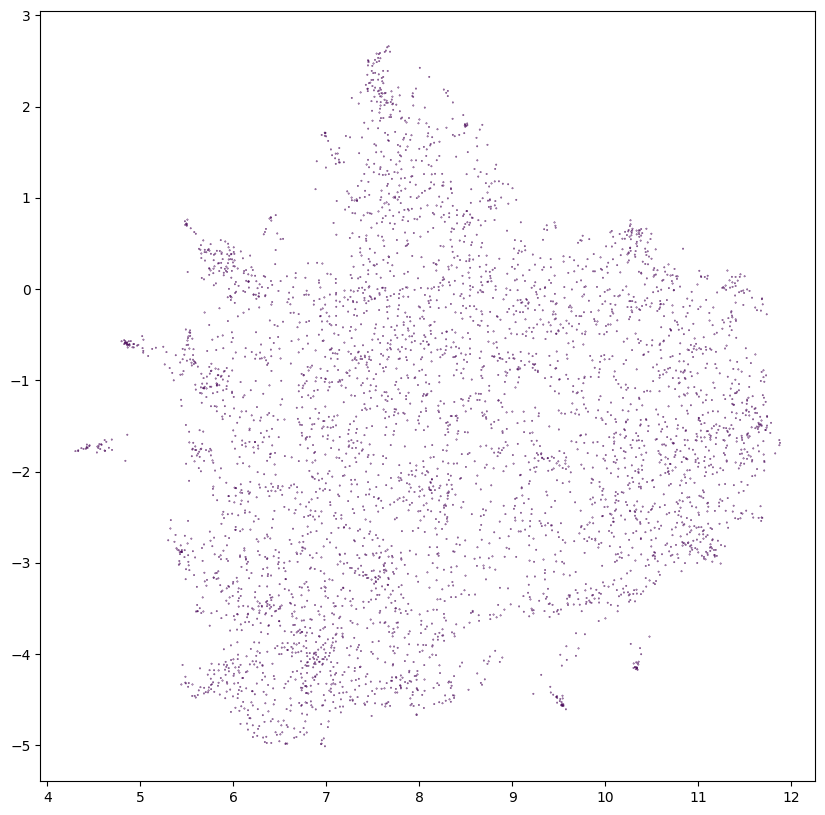

In [30]:
plt.figure(figsize=(10, 10))
plt.scatter(df_cinder["x"], df_cinder["y"], s=0.1, c=df_cinder['cluster_e'])

In [31]:
import matplotlib

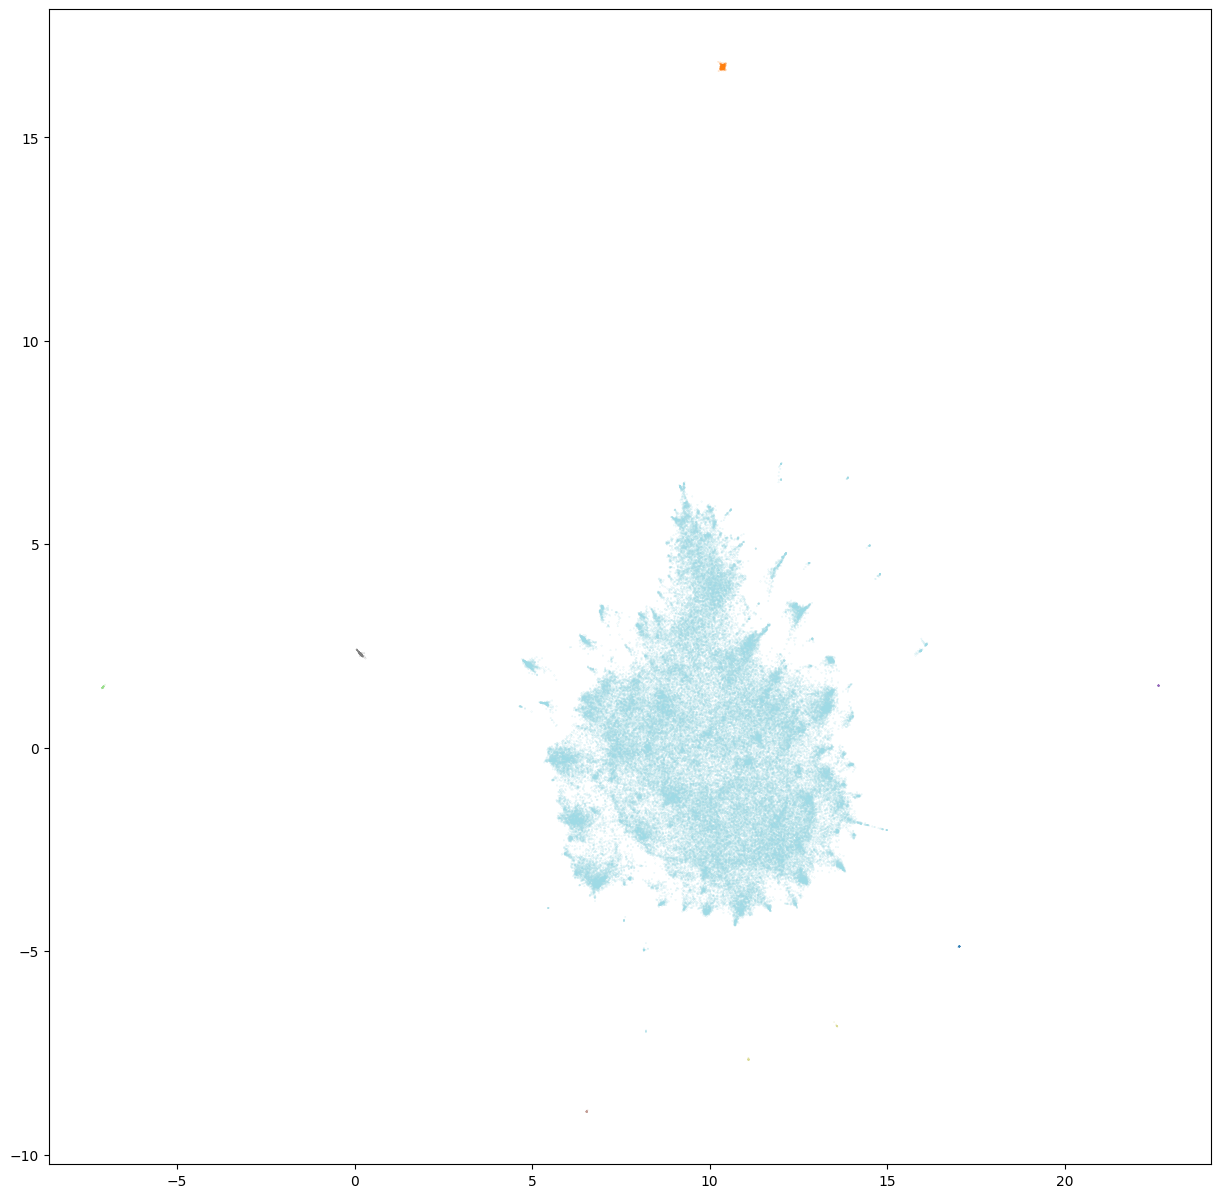

In [74]:
plt.figure(figsize=(15, 15))
plt.scatter(df_processing["x"], df_processing["y"], s=0.01, c=df_processing['cluster'], cmap=plt.get_cmap('tab20'))

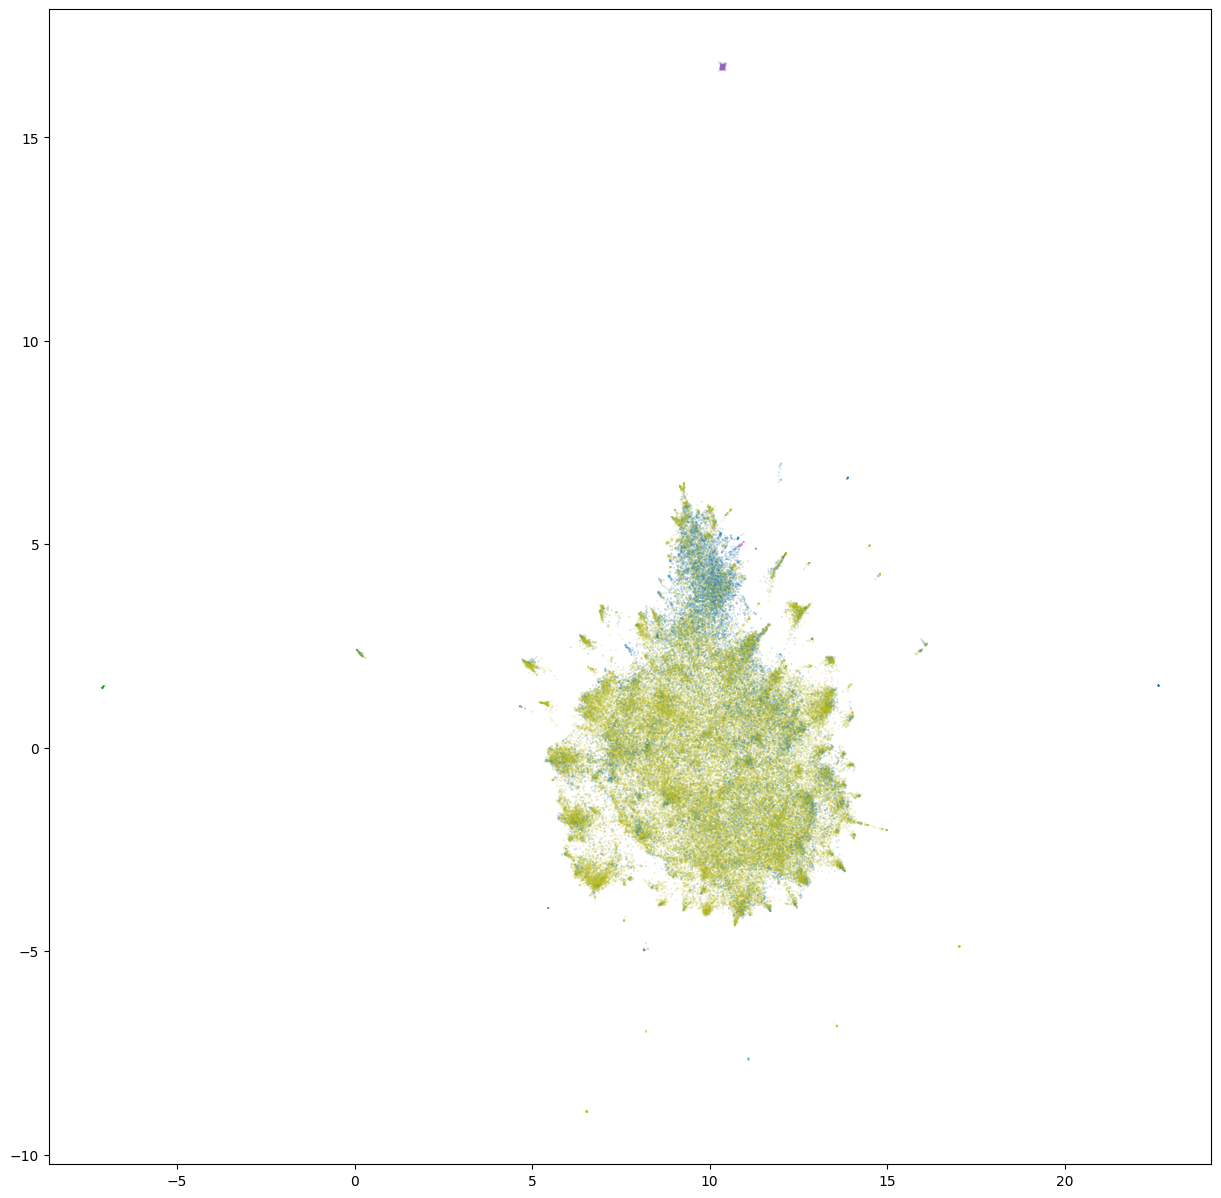

In [33]:
plt.figure(figsize=(15, 15))
plt.scatter(df_processing["x"], df_processing["y"], s=0.01, c=df_processing['cluster_e'], cmap=plt.get_cmap('tab20'))

In [34]:
df_processing['cluster'].value_counts()

cluster
 14    91340
 12      827
 0       648
 8       609
 13      402
 3       366
 11      271
 10      226
 9       175
 1       168
 5       150
-1       142
 6        53
 7        38
 4        35
 2        31
Name: count, dtype: int64

In [35]:
df_processing['cluster_e'].value_counts()

cluster_e
 3    73385
-1    21207
 1      647
 0      167
 4       43
 2       32
Name: count, dtype: int64

In [36]:
df_cinder['cluster'].value_counts()

cluster
 1    4023
-1     404
 0      34
Name: count, dtype: int64

In [37]:
df_cinder['cluster_e'].value_counts()

cluster_e
-1    4461
Name: count, dtype: int64

_________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

### extract most frequent keywords

In [79]:
# extract keywords/tokens
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

In [80]:
nlp = spacy.load("en_core_web_sm") # small model

# enabling tqdm for pandas -> progress bar
tqdm.pandas()

In [81]:
df_processing['parsed'] = df_processing['strip_cooked'].progress_apply(nlp)
df_cinder['parsed'] = df_cinder['strip_cooked'].progress_apply(nlp)

  0%|          | 0/95481 [00:00<?, ?it/s]

  0%|          | 0/4461 [00:00<?, ?it/s]

In [82]:
from collections import Counter
import itertools

In [83]:
def get_most_common_lemmas(df, column_name, top_n=20):

    # flattening all lemmas into a single list
    all_lemmas = list(itertools.chain.from_iterable(
        [token.lemma_.lower() for token in doc if token.is_alpha] for doc in df[column_name]
    ))

    # Count lemma frequencies
    lemma_counts = Counter(all_lemmas)

    # Return the most common lemmas
    return lemma_counts.most_common(top_n)

In [84]:
get_most_common_lemmas(df_processing, column_name='parsed', top_n=20)

[('the', 314505),
 ('be', 205633),
 ('i', 203397),
 ('to', 191482),
 ('a', 139018),
 ('and', 115327),
 ('you', 106154),
 ('it', 103481),
 ('in', 84158),
 ('of', 82015),
 ('that', 71186),
 ('for', 65941),
 ('do', 63850),
 ('this', 62892),
 ('have', 55529),
 ('use', 48343),
 ('with', 48289),
 ('can', 44472),
 ('but', 43893),
 ('on', 43131)]

In [182]:
CUSTOM_STOP_WORDS_P = set() 
CUSTOM_STOP_WORDS_C = set()
CUSTOM_STOP_WORDS_O = set()

def clean_tokens(text, CUSTOM_STOP_WORDS=CUSTOM_STOP_WORDS_P):
    return [
        token.lemma_.lower().strip() # take the lemma (base form), lowercase, remove extra spaces
        for token in text
        if token.pos_ in {'PROPN', 'NOUN'} # 'VERB' # keeping only proper nouns and common nouns and verbs, based on POS tags
        and token.is_alpha # excluding tokens with non-alphabetic characters (e.g. numbers, punctuation)
        and token.lemma_.lower() not in STOP_WORDS # exclude predefined stopwords
        and token.lemma_.lower() not in CUSTOM_STOP_WORDS # exclude custom stopwords
    ]

In [183]:
df_processing['lemmas'] = df_processing['parsed'].apply(clean_tokens)
df_cinder['lemmas'] = df_cinder['parsed'].apply(clean_tokens)

In [184]:
def get_most_common_lemmas_2(df, column_name, top_n=20):

    # flattening all lemmas into a single list
    all_lemmas = list(itertools.chain.from_iterable(df[column_name]))

    # Count lemma frequencies
    lemma_counts = Counter(all_lemmas)

    # Return the most common lemmas
    return lemma_counts.most_common(top_n)

In [185]:
get_most_common_lemmas_2(df_processing, column_name='lemmas', top_n=20)

[('code', 39469),
 ('processing', 34428),
 ('function', 15345),
 ('file', 15161),
 ('example', 15010),
 ('thank', 13788),
 ('library', 13440),
 ('image', 13408),
 ('sketch', 12781),
 ('way', 12482),
 ('time', 12181),
 ('line', 12169),
 ('problem', 11328),
 ('value', 10477),
 ('class', 10219),
 ('array', 9166),
 ('error', 8857),
 ('point', 7914),
 ('object', 7450),
 ('color', 7198)]

In [186]:
get_most_common_lemmas_2(df_cinder, column_name='lemmas', top_n=20)

[('cinder', 2938),
 ('thank', 1156),
 ('code', 971),
 ('texture', 835),
 ('way', 832),
 ('app', 827),
 ('file', 791),
 ('project', 790),
 ('time', 714),
 ('shader', 674),
 ('sample', 650),
 ('window', 631),
 ('issue', 631),
 ('error', 559),
 ('example', 556),
 ('thing', 546),
 ('problem', 533),
 ('video', 481),
 ('function', 473),
 ('datum', 449)]

In [187]:
threshold_p = 13000
CUSTOM_STOP_WORDS_P.update([word for word, freq 
                            in get_most_common_lemmas_2(df_processing, 'lemmas', top_n=20)
                            if freq > threshold_p])

threshold_c = 700
CUSTOM_STOP_WORDS_C.update([word for word, freq 
                            in get_most_common_lemmas_2(df_cinder, 'lemmas', top_n=20)
                            if freq > threshold_c])

In [188]:
df_processing['lemmas'] = df_processing['parsed'].apply(
    lambda text: clean_tokens(text, CUSTOM_STOP_WORDS=CUSTOM_STOP_WORDS_P)
)

In [189]:
df_cinder['lemmas'] = df_cinder['parsed'].apply(
    lambda text: clean_tokens(text, CUSTOM_STOP_WORDS=CUSTOM_STOP_WORDS_C)
)

_________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

### extract top keywords per cluster

In [190]:
# top keywords per cluster
from sklearn.feature_extraction.text import CountVectorizer

In [191]:
def extract_keywords(df, cluster='cluster', top_n=25, max_features=1000):
    results = []

    for cluster_id, group in df.groupby(cluster):
        # Vectorizing the text
        vectorizer = CountVectorizer(max_features=max_features)
        lemmas = group['lemmas'].apply(
            lambda x: " ".join(x) if isinstance(x, list) else str(x)
        )

        try:
            X = vectorizer.fit_transform(lemmas)

            # Skip if the vocabulary is empty
            if not vectorizer.vocabulary_:
                continue

            # Calculating word frequencies
            word_sums = X.sum(axis=0).A1  # Converting matrix to array
            words_freq = sorted(
                ((word, word_sums[idx]) for word, idx in vectorizer.vocabulary_.items()),
                key=lambda x: x[1], reverse=True
            )

            # Get top keywords
            top_keywords = [word for word, _ in words_freq[:top_n]]

            # Append cluster results
            results.append({'cluster': cluster_id, 'top_keywords': top_keywords})
        
        except ValueError as e:
            # Handle errors such as empty vocabulary
            print(f"Skipping cluster {cluster_id}: {e}")
            continue

    return pd.DataFrame(results)

In [192]:
keywords_cinder = extract_keywords(df_cinder)

In [193]:
keywords_processing = extract_keywords(df_processing)

Skipping cluster 0: empty vocabulary; perhaps the documents only contain stop words


In [194]:
keywords_processing_e = extract_keywords(df_processing, 'cluster_e')

Skipping cluster 1: empty vocabulary; perhaps the documents only contain stop words
Skipping cluster 2: empty vocabulary; perhaps the documents only contain stop words
Skipping cluster 4: empty vocabulary; perhaps the documents only contain stop words


In [195]:
keywords_cinder

,cluster,top_keywords
0,-1,"[video, issue, shader, sample, character, prob..."
1,0,"[gstreamer, version, video, rpi, linux, error,..."
2,1,"[shader, sample, window, issue, error, example..."


In [196]:
keywords_processing

,cluster,top_keywords
0,-1,"[reddit, vote, comment, question, os, button, ..."
1,1,"[nan, hi]"
2,2,"[reddit, idea, gear, iskeydown, balloon, popbu..."
3,3,"[el, que, de, un, la, con, una, para, lo, los,..."
4,4,"[solution, workaround, size, method, developme..."
5,5,"[je, du, de, un, et, le, que, une, ich, pour, ..."
6,6,"[forum, post, pde, button, auto, editor, symbo..."
7,7,"[keyword, try]"
8,8,"[svg, shape, line, way, vector, kb, illustrato..."
9,9,"[forum, sketchbook, language, community, andro..."


In [197]:
keywords_processing_e

,cluster,top_keywords
0,-1,"[line, kb, time, way, problem, error, class, v..."
1,0,[nan]
2,3,"[sketch, way, time, line, problem, value, clas..."


_________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

### TF-IDF

In [199]:
# tfidf
from sklearn.feature_extraction.text import TfidfTransformer

In [200]:
# tfidf
def apply_tfidf(df):
    lemmas_as_strings = df['lemmas'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x).to_numpy()

    vectorizer = CountVectorizer(lowercase=False)

    X = vectorizer.fit_transform(lemmas_as_strings)

    tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
    train_data = tfidf.fit_transform(X)
    
    print(f"Vocabulary: {vectorizer.get_feature_names_out()[:10]}")  # First 10 terms
    print(f"Shape of the document-term matrix: {X.shape}")
    print(f"Shape of the TF-IDF matrix: {train_data.shape}")

    return vectorizer, train_data

In [201]:
_, train_data_processing = apply_tfidf(df_processing)

Vocabulary: ['aa' 'aaa' 'aaaa' 'aaaaa' 'aaaaaa' 'aaaaaaaa' 'aaaaaaaaaaa'
 'aaaaaaaahhhhh' 'aaaaaaaarrrrrrrrggggggggbbbbbbbb' 'aaaaaaah']
Shape of the document-term matrix: (95481, 42201)
Shape of the TF-IDF matrix: (95481, 42201)


In [202]:
_, train_data_cinder = apply_tfidf(df_cinder)

Vocabulary: ['aa' 'aaa' 'aaaaage' 'aaaah' 'aaaand' 'aabb' 'aar' 'abandon'
 'abbreviation' 'abgr']
Shape of the document-term matrix: (4461, 6285)
Shape of the TF-IDF matrix: (4461, 6285)


_________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

In [203]:
# retry hdbscan with tfidf lemmas

In [204]:
#_, df_processing['cluster_l'] = cluster(train_data_processing) -> memory allocation issue
_, df_cinder['cluster_l'] = cluster(train_data_cinder)

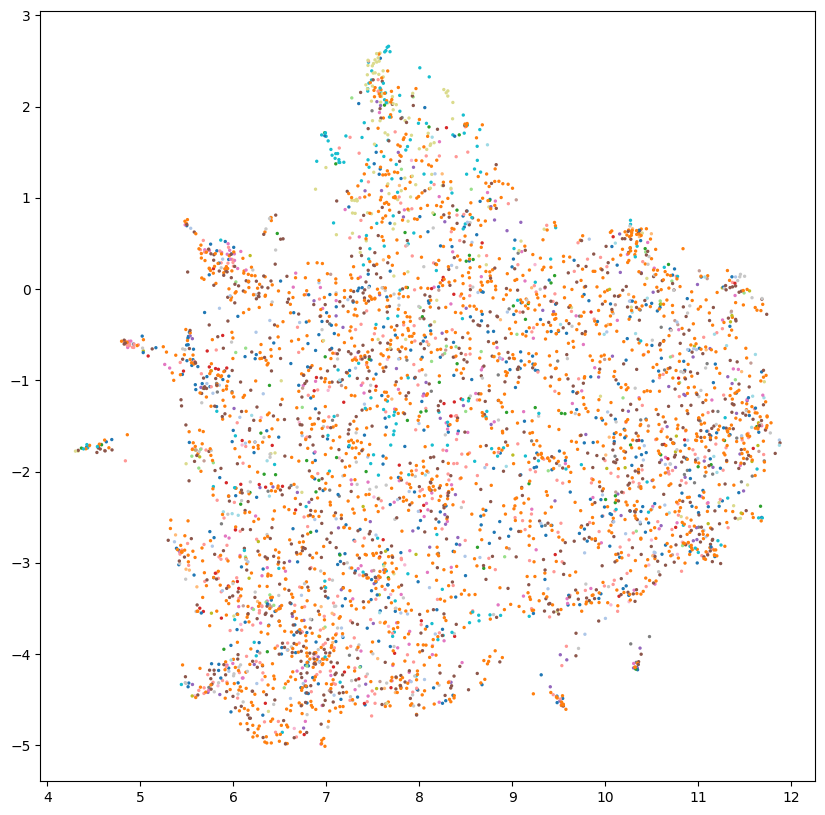

In [205]:
plt.figure(figsize=(10, 10))
plt.scatter(df_cinder["x"], df_cinder["y"], s=2, c=df_cinder['cluster_l'], cmap=plt.get_cmap('tab20'))

In [206]:
keywords_cinder = extract_keywords(df_cinder, 'cluster_l')

In [207]:
keywords_cinder

,cluster,top_keywords
0,-1,"[video, window, datum, issue, thing, example, ..."
1,0,"[problem, gpu, sample, memory, datum, thread, ..."
2,1,"[sample, shader, error, issue, example, window..."
3,2,"[matrix, camera, error, line, index, cmake, me..."
4,3,"[event, issue, thing, buffer, application, val..."
5,4,"[rotation, job, example, sample, thread, compa..."
6,5,"[error, shader, issue, function, image, window..."
7,6,"[shader, camera, issue, error, method, problem..."
8,7,"[issue, function, error, image, sample, shader..."
9,8,"[sample, shader, issue, video, block, error, f..."


In [208]:
df_cinder['cluster_l'].value_counts()

cluster_l
 1     1677
 8      785
-1      419
 6      357
 16     198
 10     165
 13     148
 15     125
 7      107
 0       92
 5       67
 3       67
 12      51
 4       42
 9       36
 14      33
 2       32
 17      30
 11      30
Name: count, dtype: int64

In [209]:
def cluster(map, min_cluster_size=30, min_samples=5, cluster_selection_epsilon=0.2, cluster_selection_method='eom'): 

    hdbscan_params = {
        'min_cluster_size': min_cluster_size, 
        'min_samples': min_samples, 
        'cluster_selection_epsilon': cluster_selection_epsilon, 
        'cluster_selection_method': cluster_selection_method # 'leaf'
    }

    
    # Ensure the input is a dense matrix if it's a sparse one
    if isinstance(map, csr_matrix):
        embedding = map 
    else:
        embedding = map.to_numpy()  # Handle pandas DataFrame or numpy array
    
    clusterer = HDBSCAN(**hdbscan_params)
    clustered = clusterer.fit_predict(embedding)

    return clusterer, clustered

In [210]:
_, df_cinder['cluster_test_1'] = cluster(train_data_cinder, min_cluster_size=80, min_samples=5, cluster_selection_epsilon=0.3, cluster_selection_method='leaf')

In [211]:
df_cinder['cluster_test_1'].value_counts()

cluster_test_1
-1     1594
 2      357
 14     274
 3      206
 8      206
 6      205
 16     192
 12     182
 10     165
 5      157
 11     148
 1      140
 13     125
 7      107
 9      107
 4      106
 15      98
 0       92
Name: count, dtype: int64

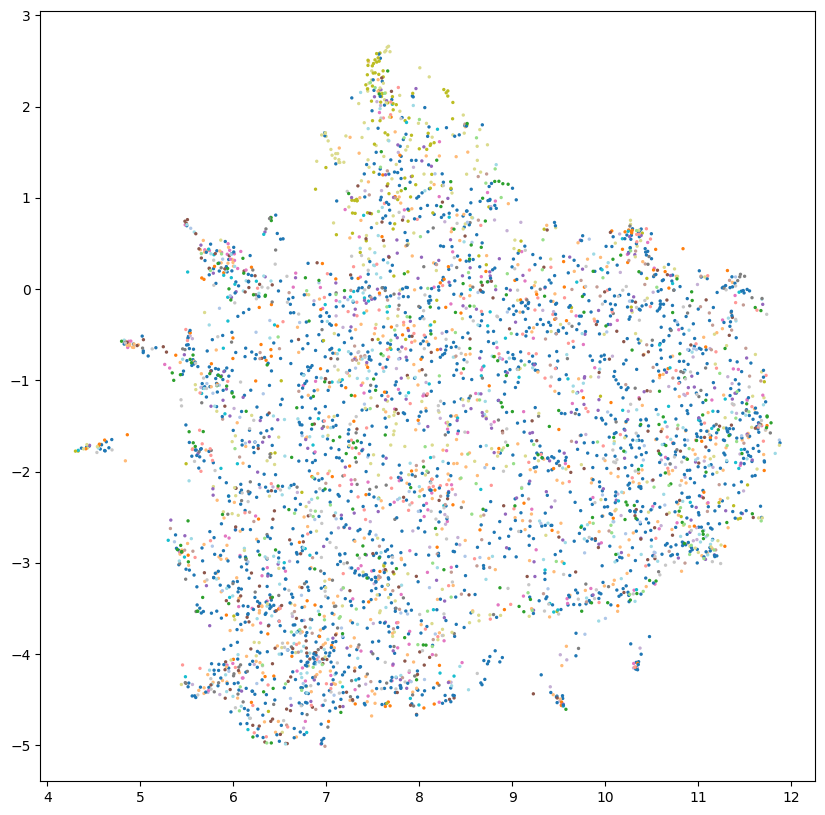

In [212]:
plt.figure(figsize=(10, 10))
plt.scatter(df_cinder["x"], df_cinder["y"], s=2, c=df_cinder['cluster_test_1'], cmap=plt.get_cmap('tab20'))

In [213]:
extract_keywords(df_cinder, 'cluster_test_1')

,cluster,top_keywords
0,-1,"[issue, sample, window, thing, shader, problem..."
1,0,"[problem, gpu, sample, memory, datum, thread, ..."
2,1,"[cmake, issue, library, bit, thing, video, pro..."
3,2,"[shader, camera, issue, error, method, problem..."
4,3,"[version, video, sample, issue, linux, gstream..."
5,4,"[issue, library, case, class, value, example, ..."
6,5,"[memory, window, error, gpu, bit, thread, issu..."
7,6,"[block, error, video, function, window, sample..."
8,7,"[issue, function, error, image, sample, shader..."
9,8,"[shader, error, example, sample, line, vertex,..."
